# Proyecto I : Dato inicial para un objeto compacto
## Formulación en coord cilindricas

In [1]:
Atom = false
#Atom = true

false

In [2]:
using Gridap
using GridapODEs
if  Atom == false
    using GridapMakie, GLMakie
end
using FileIO
using GridapGmsh
using gmsh
using Gridap.CellData
using Gridap.Visualization
using Gridap.Arrays

In [3]:
Threads.nthreads()

7

In [4]:
model = GmshDiscreteModel("modelos/rectangle_NS_Refinado.msh")

Info    : Reading 'modelos/rectangle_NS_Refinado.msh'...
Info    : 9 entities
Info    : 240011 nodes
Info    : 480020 elements                                               
Info    : Done reading 'modelos/rectangle_NS_Refinado.msh'                 


UnstructuredDiscreteModel()

In [5]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

In [6]:
writevtk(Ω,"square")

(["square.vtu"],)

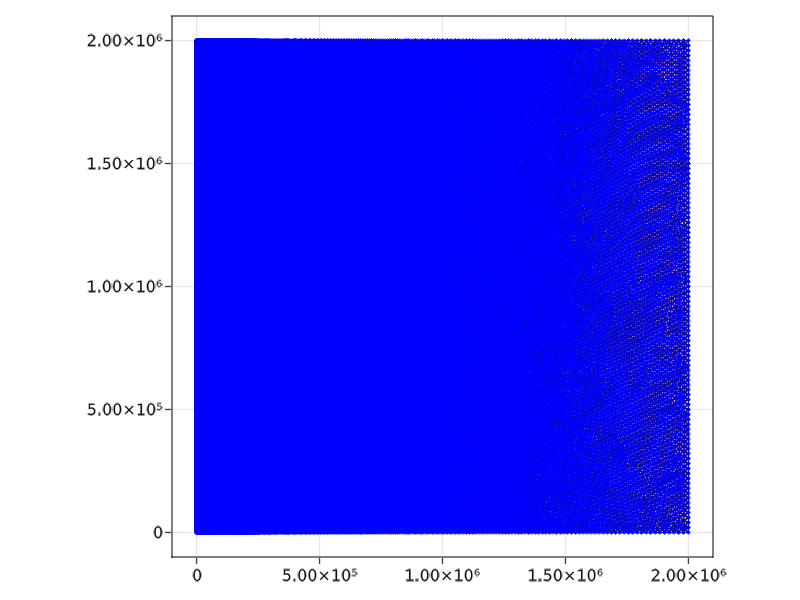

In [7]:
if Atom == false 
    fig, ax = plot(Ω)
    ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
    wireframe!(Ω, color=:black, linewidth=1)
    scatter!(Ω, marker=:star8, markersize=4, color=:blue)
    fig
end 

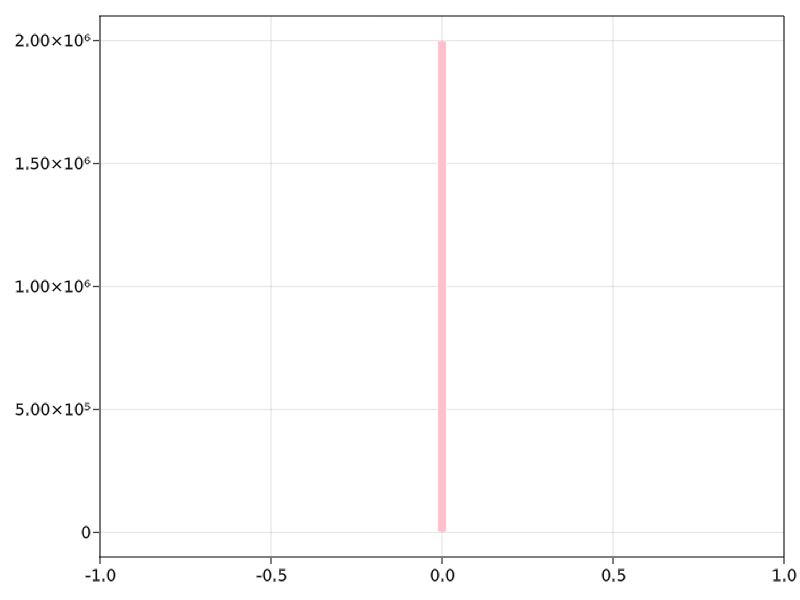

In [8]:
neumanntags_crho= ["centrorho"]
Γ_crho = BoundaryTriangulation(model,tags=neumanntags_crho)
dΓ_crho = Measure(Γ_crho,degree)
if Atom == false 
    fig = plot(Γ_crho, linewidth=8
    #, shading=true
    )
end

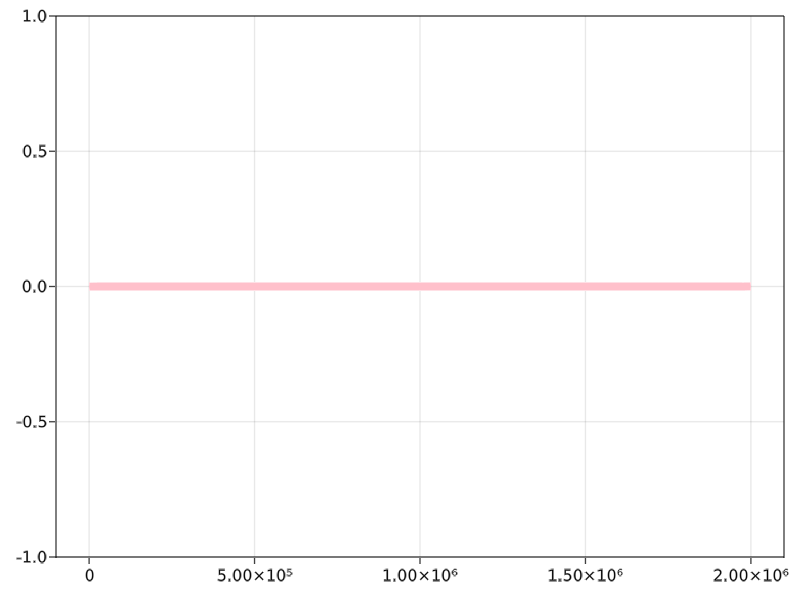

In [9]:
neumanntags_cz= [ "centroz"]
Γ_cz = BoundaryTriangulation(model,tags=neumanntags_cz)
dΓ_cz= Measure(Γ_cz,degree)
if Atom == false 
    fig = plot(Γ_cz, linewidth=8
    #, shading=true
      )
end

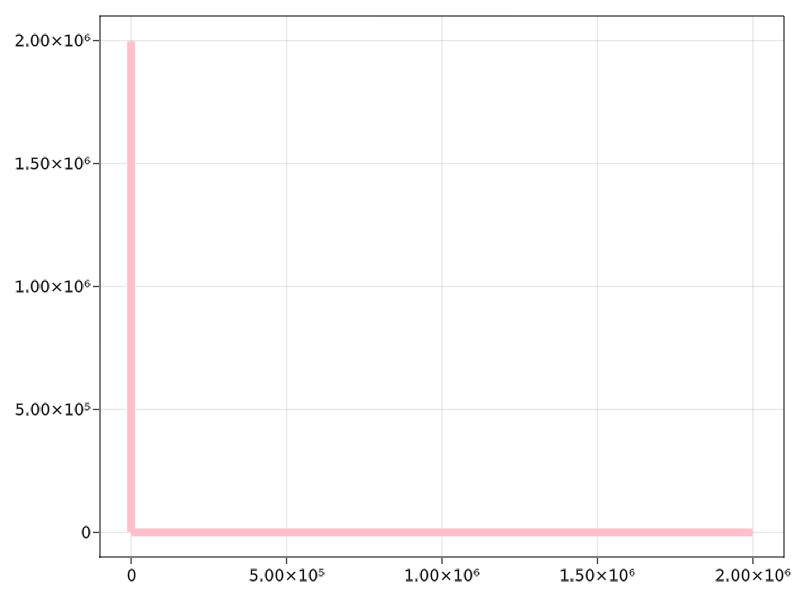

In [10]:
neumanntags_centro = [ "centroz", "centrorho"]
Γ_centro = BoundaryTriangulation(model,tags=neumanntags_centro)
dΓ_centro = Measure(Γ_centro,degree)
if Atom == false 
    fig = plot(Γ_centro, linewidth=8
    #, shading=true
    )
end

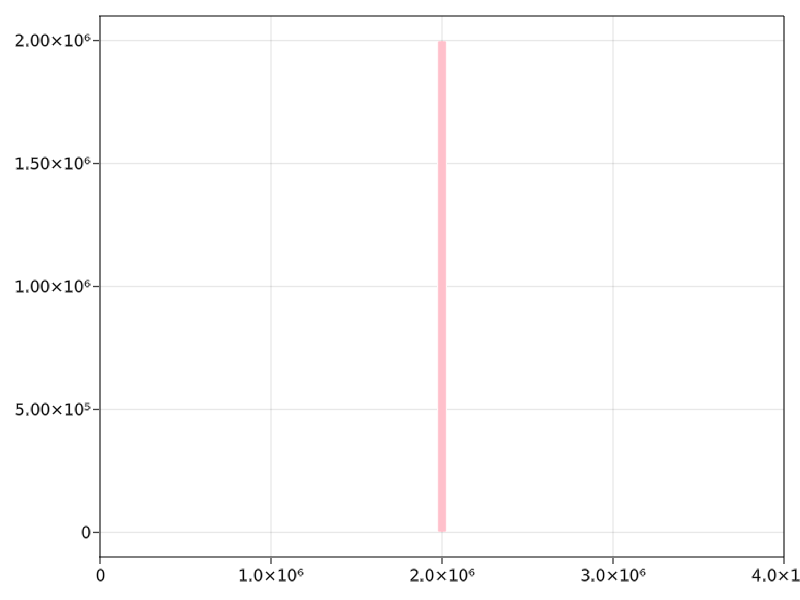

In [11]:
neumanntags_extrho = [ "asintrho"]
Γ_extrho = BoundaryTriangulation(model,tags=neumanntags_extrho)
dΓ_extrho = Measure(Γ_extrho,degree)
if Atom == false 
    fig = plot(Γ_extrho, linewidth=8
    #, shading=true
   )
end    

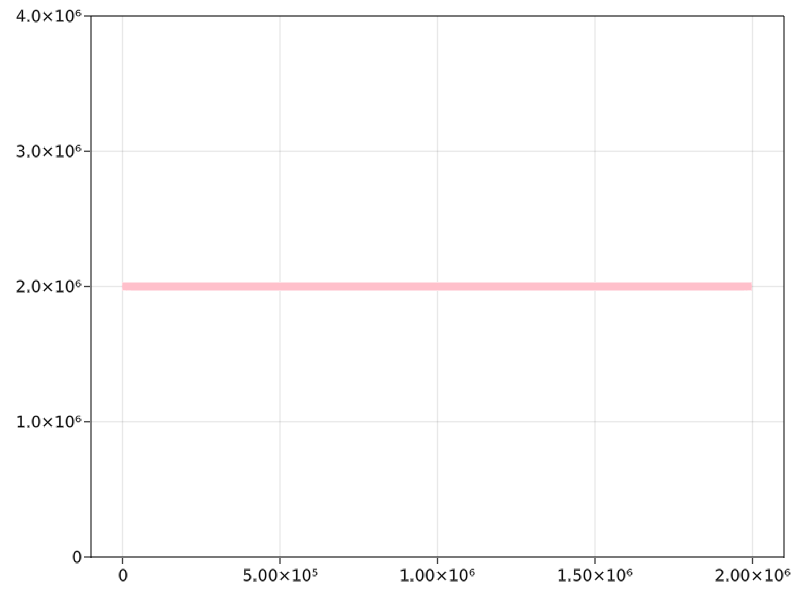

In [12]:
neumanntags_extz = [  "asintz" ]
Γ_extz = BoundaryTriangulation(model,tags=neumanntags_extz)
dΓ_extz = Measure(Γ_extz,degree)
if Atom == false 
    fig = plot(Γ_extz, linewidth=8
    #, shading=true
   )
end   

In [13]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,conformity=:H1)
U = TrialFESpace(V)

UnconstrainedFESpace()

In [14]:
SB= true
# true Spherical objet
# false  Concave objet

true

In [15]:
# fuente, a tiene la info del objeto 
a0=6.0E-18

#Shperical Body
R=7.5E5
Z=7.3E5

#Concave body
B=5.0E5
D= 0.3

function s(x)
    if SB == true
        return sqrt((x[1]/ R)^2 + (x[2]/Z)^2) 
        end
    if !SB == true
       return  sqrt((x[1])^2 + (x[2])^2 ) /( B *(D + (x[1]^2 /(x[1]^2 +x[2]^2 +0.00000001)) )  ) #((x[1])^2 + (x[2])^2 )^(3/2) /( B *(D* x[2]^2 +(D+1.)*x[1]^2 )  )
       end
end

q(x)=1. - s(x) ^4 * (1. - 5. *(s(x) -1.) + 15. * (s(x)-1.)^2 - 35. *(s(x) -1.)^3 +70. * (s(x)- 1.)^4)

function α(x)
  if s(x)  < 1.
        return q(x)*a0
        end
    if s(x) >= 1.
       return  0.
    end
end
t(x) = 8*π*α(x)

#Cond de Newman borde centro
c(x)=0.


c (generic function with 1 method)

In [16]:
if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/α_spherical_ref",cellfields=["α"=>α])
end
if !SB == true
    return  writevtk(Ω,"resultados/Proyecto1/NS/α_concave_ref",cellfields=["α"=>α])
end

In [17]:
d(x) = VectorValue(2. ,0)
conv(l,∇t) = (∇t')⋅l

conv (generic function with 1 method)

In [18]:
ρ(x)=x[1]
ρvec(x) = VectorValue(1.,0)
zvec(x) = VectorValue(0,1.)
z(x)=x[2]

z (generic function with 1 method)

In [19]:
a(u,v) = ∫( (d  ⋅ ∇(u))*v - ∇(v) ⋅ ∇(u)*ρ  ) *dΩ + ∫( -v *( u +(zvec ⋅ ∇(u))*z) ) *dΓ_extrho +   ∫(- v *(u * ρ/z +(ρvec ⋅ ∇(u))*ρ*ρ/z) ) *dΓ_extz  
b(v) = ∫(-v * t* ρ) *dΩ + ∫( c * v *ρ ) *dΓ_centro

b (generic function with 1 method)

In [20]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [21]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [22]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 477288
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12663915975506067509

In [23]:
if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/f_spherical_ref",cellfields=["f"=>uh])
end
if !SB == true
    return  writevtk(Ω,"resultados/Proyecto1/NS/f_concave_ref",cellfields=["f"=>uh])

end

if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/∇f_spherical_ref",cellfields=["∇f"=>∇(uh)])
end
if !SB == true
    return  writevtk(Ω,"resultados/Proyecto1/NS/∇f_concave_ref",cellfields=["∇f"=>∇(uh)])

end

In [24]:
invrho3(x)=3. / x[1]

invrho3 (generic function with 1 method)

In [25]:
f1=conv∘(ρvec,∇(uh))
f2=conv∘(zvec,∇(uh))
F=f2*f2 +f1*f1

OperationCellField():
 num_cells: 477288
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12663915975506067509

In [26]:
Residual_f_cuad =( Δ(uh)+invrho3 *f1+t)* ( Δ(uh)+invrho3 *f1+t )

OperationCellField():
 num_cells: 477288
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12663915975506067509

In [27]:
L2norm_residual_f= sqrt(sum( ∫( Residual_f_cuad)*dΩ ))

1.3753575941957805e-13

In [28]:
if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/residualf_spherical_ref",cellfields=["res"=>Δ(uh)+invrho3 *f1+t])
end
if !SB == true
    return  writevtk(Ω,"resultados/Proyecto1/NS/residualf_concave_ref",cellfields=["res"=>Δ(uh)+invrho3 *f1+t])
end

### Factor conforme

In [29]:
function t1(x)
  return 2. * π*α(x)
end

function t2(x)
  return 6. * π*α(x)
end

t2 (generic function with 1 method)

In [30]:
res(w,w2)=  ∫(  - (∇(w2) ⋅ ∇(w))*ρ  + t1 *( (w2*ρ * ρ)/(w*w*w)) + (0.25 * F *ρ *  ρ* ρ) * w2*(1/(w*w*w*w*w*w*w))) *dΩ +∫( c * w2 *ρ ) *dΓ_centro +∫( -w2 *( (w- 1.) +(zvec ⋅ ∇(w))*z) ) *dΓ_extrho +   ∫( -w2 *( (w -1. )*ρ/z +(ρvec ⋅ ∇(w))*ρ*ρ/z) ) *dΓ_extz

res (generic function with 1 method)

In [31]:
jac(w,dw,w2)= ∫(  - ( ∇(w2) ⋅ ∇(dw))*ρ   - ((dw* w2*ρ *  ρ)/(w*w*w*w))*t2   -(1.75 * F *ρ  * ρ* ρ) * dw *w2*(1/(w*w*w*w*w*w*w*w))   ) *dΩ +∫( -w2 *( (dw#=- 1.=#) +(zvec ⋅ ∇(dw))*z) ) *dΓ_extrho +   ∫( -w2 *( (dw #=-1.=# )*ρ/z +(ρvec ⋅ ∇(dw))*ρ*ρ/z) ) *dΓ_extz 

jac (generic function with 1 method)

In [32]:
oppsi = FEOperator(res,jac,U,V)

FEOperatorFromWeakForm()

In [33]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:newton, linesearch=BackTracking(),ftol=1E-15, xtol= 1E-20,iterations=50)
solver = FESolver(nls)

NonlinearFESolver()

In [34]:
seed(x)=1.
w02=interpolate_everywhere(seed,U)

SingleFieldFEFunction():
 num_cells: 477288
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12663915975506067509

In [35]:
w, = solve!(w02,solver,oppsi)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.769914e+01              NaN
     1     3.147680e+01     1.075556e+03
     2     2.556925e+01     8.412385e+02
     3     1.878345e+01     8.472484e+02
     4     1.320301e+01     9.451099e+02
     5     6.527828e+00     9.626131e+02
     6     1.134912e-01     4.670681e+00
     7     3.011141e-04     2.660325e-02
     8     2.493238e-09     8.786963e-08
     9     2.583278e-09     1.674540e-18
    10     2.359201e-09     5.557830e-26
    11     1.930403e-09     4.600972e-26
    12     2.123784e-09     1.684575e-26
    13     1.659544e-09     5.114161e-27
    14     1.659544e-09     1.617584e-27
    15     1.605656e-09     2.676457e-27
    16     1.605656e-09     1.203506e-27
    17     1.605656e-09     1.001853e-28
    18     1.605656e-09     1.196850e-29
    19     1.630497e-09     1.365592e-27
    20     1.630497e-09     6.138570e-28
    21     1.630497e-09     1.727482e-28
    22     1.63049

(SingleFieldFEFunction(), NLSolversCache())

In [36]:
if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/Fact_spherical_ref",cellfields=["ψ"=>w])
end
if !SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/Fact_concave_ref",cellfields=["ψ"=>w])
end

In [37]:
invrho(x)=1/x[1]

invrho (generic function with 1 method)

In [38]:
if SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/residualFact_spherical_ref",cellfields=["resi"=>Δ(w)+invrho* (ρvec ⋅ ∇(w))+ t1 * (  ρ/(w*w*w))+  (0.25 * F *ρ *   ρ) * (1/(w*w*w*w*w*w*w))])
end
if !SB == true
    return writevtk(Ω,"resultados/Proyecto1/NS/residualFact_concave_ref",cellfields=["resi"=>Δ(w)+invrho* (ρvec ⋅ ∇(w))+ t1 * (  ρ/(w*w*w))+  (0.25 * F *ρ *   ρ) * (1/(w*w*w*w*w*w*w))])
end

In [39]:
Residual_fac_cuad =( Δ(w)+invrho* (ρvec ⋅ ∇(w))+ t1 * (  ρ/(w*w*w))+  (0.25 * F *ρ *   ρ) * (1/(w*w*w*w*w*w*w)))* ( Δ(w)+invrho* (ρvec ⋅ ∇(w))+ t1 * (  ρ/(w*w*w))+  (0.25 * F *ρ *   ρ) * (1/(w*w*w*w*w*w*w)) )

OperationCellField():
 num_cells: 477288
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 12663915975506067509

In [40]:
L2norm_residual_fac= sqrt(sum( ∫( Residual_fac_cuad)*dΩ ))

5.749937811536573e-8